# MNIST Dataset 

* Dataset used to prove image recognition can be done with machine learning
* Images are grayscale 28 x 28
* Digits 0-9
* Goal here is OCR (Optical Character Recognition)

In [1]:
# Imports - tensorflow, numpy (a numerical library very common in scientific applications) and plotting library.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from AccuracyHistory import AccuracyHistory, MSEHistory #locally defined class, don't worry about the workings of this now
tf.random.set_seed(49)

In [2]:
# MNIST is a classic learning dataset and is provided as part of tensorflow.
# It will be automatically downloaded if you do not have it already.
mnist = keras.datasets.mnist

# Train and test partition split

* As mentioned before, this must be done to properly judge model performance
* MNIST knows you want to do this
* Data preprocessing is done for you here but can be a very manual and time consuming process
* Presentation with library about data handling coming in spring, it can be very involved

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print(train_images.shape)

(60000, 28, 28)


60,000 pictures (each 28x28 pixels)

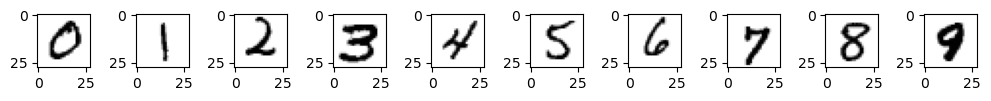

In [4]:
# BUT WHAT DO THEY LOOK LIKE? I looked at mnist and found indexes with a sample of each digit
numerical_indexes = [1,8,122,111,9,332,4572,223,333,1333]
# Finally we will answer what these images look like.
fig, axes = plt.subplots(1, 10, figsize=(10,10))
for n in range(0,len(numerical_indexes)):
    axes[n].imshow(train_images[numerical_indexes[n]],  cmap=plt.cm.binary)
plt.tight_layout()
plt.show()

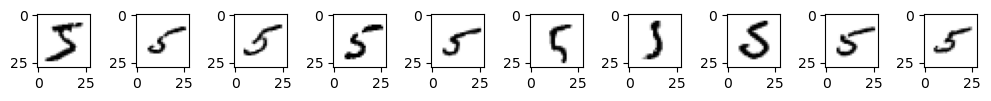

In [5]:
#Let's print 10 variations of 5
variations = 0
fig, axes = plt.subplots(1, 10, figsize=(10,10))
for n in range(0,60000):
    if train_labels[n] == 5:
         axes[variations].imshow(train_images[n], cmap=plt.cm.binary)
         variations += 1
    if variations == 10:
        break
plt.tight_layout()
plt.show()        

# Is dataset balanced?

* By which we mean, are all classes represented equally?
* A dataset that is imbalanced can lead to many different problems.
* e.g. You are doing binary classification so your classes are 0 or 1. Your dataset is 95% 0.
* A model can get a very good score just by predicting 0 all the time.

In [6]:
class_counts = np.zeros(10) #MNIST is for digits 0-9 for total of 10
for i in range(len(train_labels)):
    class_counts[train_labels[i]] += 1
for i in range(len(class_counts)):
    print(i, ":", str(class_counts[i] / len(train_labels)))

0 : 0.09871666666666666
1 : 0.11236666666666667
2 : 0.0993
3 : 0.10218333333333333
4 : 0.09736666666666667
5 : 0.09035
6 : 0.09863333333333334
7 : 0.10441666666666667
8 : 0.09751666666666667
9 : 0.09915


In the dataset, number of 1s are the greatest, followed by 7s, then 3s, and so on.

Not perfectly balanced but close enough.

# Class question: What is close enough?

In [7]:
# Small preprocessing note - we want to scale image values to between 0 and 1
print(train_images[333])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  87 138 170 253 201 244 212
  222 138  86  22   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  95 253 252 252 252 252 253 252
  252 252 252 245  80   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  68 246 205  69  69  69  69  69  69
   69  69 205 253 240  50   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 187 252 218  34   0   0   

# Exploding gradient problem - scale our data to between 0 and 1

In [8]:
# Get the global minimum and maximum pixel values
min_val = train_images.min()
max_val = train_images.max()

# Apply the MinMax formula to the entire array
train_images = (train_images - min_val) / (max_val - min_val)

# Optional: Print to verify the new range
print(f"Original min: {min_val}, max: {max_val}")
print(f"New max: {train_images.max()}")

# Now do same for test
test_images = (test_images - min_val) / (max_val - min_val)


Original min: 0, max: 255
New max: 1.0


# Side note:

* We are going to change the shape of our images so we can use a special plotting library at the end
* This library requires images to have 3 "dimensions."
* MNIST images are 28x28 but we are going to reshape them to 28x28x1
* This is because most pictures used in convolutional neural networks have 3 values per pixel (RGB)
* MNIST images are grayscale so only have a single value per pixel.


In [9]:
print("Before reshape", train_images.shape)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)
print("After reshape", train_images.shape)

Before reshape (60000, 28, 28)
After reshape (60000, 28, 28, 1)


# Define model

* Recall diagram - Models are made of multiple layers, each of which contains a number of units.
* How many layers? How many hidden units in each layer? 
* Some tips to start: keep it simple. Simpler networks generalize better (similar performance to train and test data).

In [10]:
#This is basically one line in Keras
model = keras.Sequential()

# Defining First layer

<img src="../images/Backprop.jpg" width="400" height="400" align=right />

* First layer must be equal in size to an individual item in your dataset.
* We will specify the 28 x 28 resolution of each individual image in mnist.
* Flatten here is really important - it expands 28 x 28 into 784 consecutive numbers - this could be any kind of data, not just pictures!

In [ ]:
train_images[0].shape #check

(28, 28, 1)

In [12]:
model.add(keras.layers.Flatten(input_shape=train_images[0].shape)) 
# MNIST images are 28 x 28, Flatten turns this into 1-D array of 784 (28 x 28)

d:\Anaconda3_24.10\envs\tfenv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Defining Second layer

* The number of hidden units should be between the size of the input layer and the size of the output layer
* If you want an exact formula, sadly there isn't one.

In [14]:
model.add(keras.layers.Dense(128, activation='relu'))

# Third layer

* For MNIST, this will be the number of categories of our target. How many do we have?
  

In [15]:
model.add(keras.layers.Dense(10))

# Output Layer

* This network will output a series of raw prediction numbers (aka logits) for each class
* Q: What if we want probabilities rather than raw numbers?
* A: Add a softmax layer to this. We will do that later in this notebook

In [16]:
#This is basically one line in Keras
model.add(keras.layers.Softmax())  # Converts raw math numbers to human-readable probabilities that sum to 1.0


# In Tensorflow, creating model topology is the first step

* Now we have to deal with the other components I mentioned

#  Pop quiz - what were they?  

# Loss function 
* If your data is all 0s or 1s, you would use BinaryCrossentropy
* If you have multiple classes, you would want either CategoricalCrossentropy or SparseCategoricalCrossentropy
* If you were doing regression, you would probably use MeanSquaredError

# What do our targets really look like?


In [17]:
# What kind of targets do we have and how are they encoded?
np.unique(train_labels)
# What should we use from the above?

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Answer

* Because the labels are from 0-9, this means we should use SparseCategoricalCrossentropy
* If label looked like [0,0,1,0,0,0,0,0,0,0] indicating 2 (also known as one-hot encoding), 
 we would use CategoricalCrossentropy.
* Next step after model creation is compilation

In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Epochs

* Epochs are how many times we do the training loop from the diagram above
* This has a dramatic effect on training time
* if you don't curtail it with EarlyStopping, which we will discuss briefly but not implement.

In [19]:
epochs=3
history=AccuracyHistory() #User made class we will discuss later
model.fit(train_images, train_labels, epochs=epochs, callbacks=[history]) # fit means train, old terminology

Epoch 1/3
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4013 - sparse_categorical_accuracy: 0.8846{'loss': 0.22905509173870087, 'sparse_categorical_accuracy': 0.9325000047683716}
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.4003 - sparse_categorical_accuracy: 0.8849
Epoch 2/3
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.9672{'loss': 0.09499313682317734, 'sparse_categorical_accuracy': 0.9706833362579346}
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.9673
Epoch 3/3
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0708 - sparse_categorical_accuracy: 0.9782{'loss': 0.06485675275325775, 'sparse_categorical_accuracy': 0.9803333282470703}
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0707 - sparse_categorical_accuracy: 0.9782


# Accuracy sidebar

* for classification, what is good enough?

* Baseline aka the floor - what would a bad model predict if it predicted the same thing every time and didn't learn anything?

# Class question: what is the baseline accuracy for MNIST?

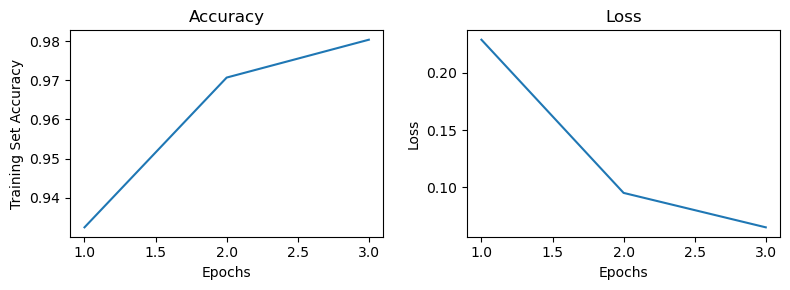

In [20]:
#Plot accuracy and loss graphs
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(range(1, epochs + 1), history.acc)
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Set Accuracy')

axes[1].plot(range(1, epochs + 1), history.loss)
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Analysis
* MNIST is a simple problem that was pretty well learned after 2 epochs
* It gives us the classic graphs of what SHOULD happen - accuracy goes up over time and loss goes down over time
* Too much training can result in overfitting
* your model's training performance looks good but it does not generalize well on test data.

# Speaking of which, time for the moment of truth

* How well does this model do on test data it has not seen before?

313/313 - 1s - 3ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9724

Test accuracy: 0.9724000096321106


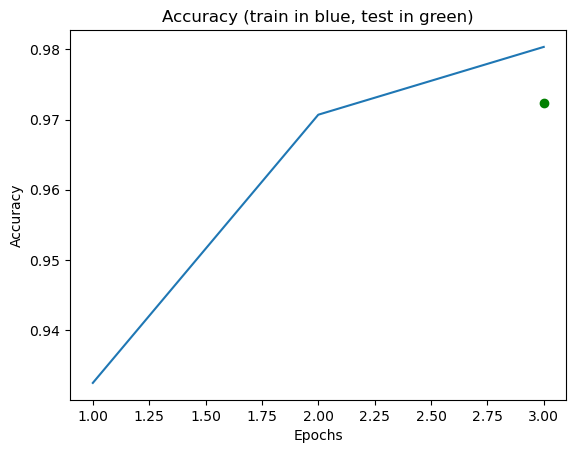

In [21]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
#Plot accuracy and loss graphs
plt.xlabel('Epochs')
plt.plot(range(1, epochs + 1), history.acc)
plt.plot([epochs], [test_acc], color='green', marker='o')
plt.title('Accuracy (train in blue, test in green)')
plt.ylabel('Accuracy')
plt.show()

# Looks close!

* If this number was significantly lower than our training accuracy, that would indicate overfitting.

* Define significant...

In [24]:
# What do predictions look like?
np.set_printoptions(suppress=True)
predictions = model.predict(test_images)
print(predictions[3])
# should add up to 1.0
print(f'Sum: {np.sum(predictions[3])}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[0.99780804 0.00000049 0.00001008 0.00004751 0.00002746 0.00001802
 0.00008019 0.00001273 0.00000414 0.00199129]
Sum: 0.9999999403953552


# Probabilities are more human readable

* Probabilities for each class are good for seeing where your model might be getting confused

# Black Box problem

* For years, machine learning has been criticized for being a black box. 
* Seeing a probability is nice but in many cases, we will want to know why the model decided as it did. 
* For instance, there can be discrimination possibilities if a model uses certain information.
* Legally protected information should be left out of a model entirely but as we see with AI, many times questionable sources are used in model training.

# Shapley values to the rescue

* Shapley values use permutation-based game theory to open the black box and see why a model decided as it did.

d:\Anaconda3_24.10\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda3_24.10\envs\tfenv\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
d:\Anaconda3_24.10\envs\tfenv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(4000, 28, 28, 1))']
  warnings.warn(msg)
d:\Anaconda3_24.10\envs\tfenv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['T

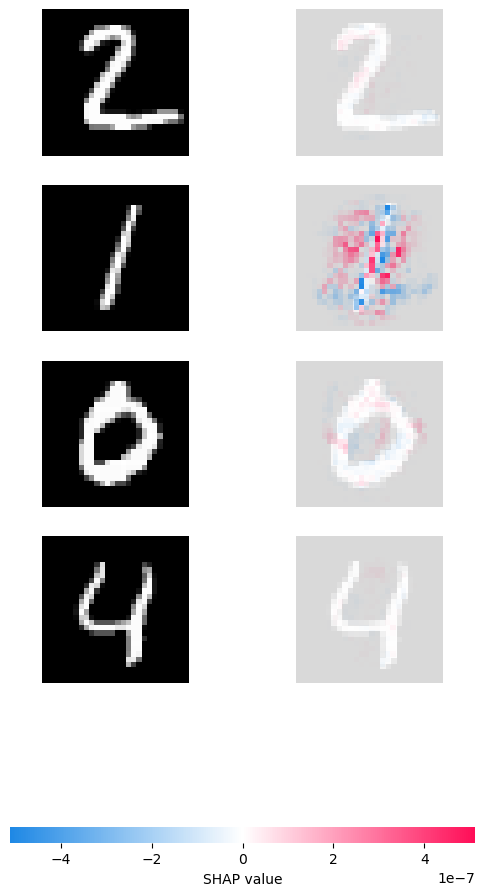

array([[0.00000029, 0.00689757, 0.9929103 , 0.00002745, 0.        ,
        0.00003528, 0.00000029, 0.00000175, 0.00012703, 0.00000002],
       [0.00001006, 0.99932826, 0.00007697, 0.000001  , 0.00004285,
        0.00000685, 0.00000311, 0.00047427, 0.00005415, 0.00000236],
       [0.99780804, 0.00000049, 0.00001008, 0.00004751, 0.00002746,
        0.00001802, 0.00008019, 0.00001273, 0.00000414, 0.00199129],
       [0.00000304, 0.00000087, 0.00000079, 0.00000009, 0.97487396,
        0.00000016, 0.00000177, 0.00010509, 0.00000214, 0.02501201]],
      dtype=float32)

In [25]:
import shap
background = train_images[np.random.choice(train_images.shape[0], 4000, replace=False)]
e = shap.DeepExplainer(model, background) # train_images)
# Get the values. Ranked_outputs = 2 means the two highest ranked possible classes for each image.
shap_values = e.shap_values(test_images[1:5])
# plot the feature attributions
# Red pixels represent positive SHAP values that increase the probability of the class, 
# while blue pixels represent negative SHAP values the reduce the probability of the class
shap.image_plot(shap_values, test_images[1:5]) #, index_names)
predictions[1:5]

(28, 28, 1)


d:\Anaconda3_24.10\envs\tfenv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 28, 28, 1))']
  warnings.warn(msg)


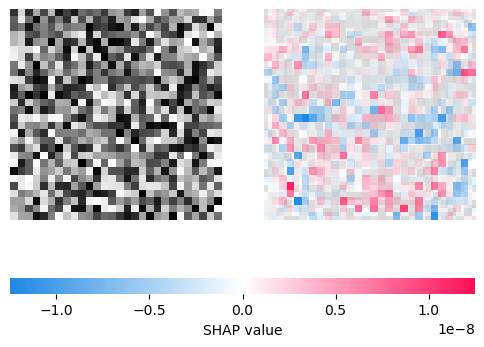

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.00000003 0.00000985 0.00292908 0.9654799  0.00000002 0.00984996
  0.00000014 0.00000531 0.02171714 0.00000857]]


In [26]:
#But what if some of your data is bad? Let's look at a randomly generated image.
randomImg = np.array([np.random.rand(28,28)])
randomImg = randomImg.reshape(28,28,1)
print(randomImg.shape)
randomImg = np.array([randomImg])
random_shapvalues = e.shap_values(randomImg)
shap.image_plot(random_shapvalues, randomImg)
print(model.predict(randomImg))

# If you're a hammer...

<BR><BR><BR><BR><BR>

# What if we do something wrong?
* MNIST is categorical but what if we treated it like regression?

* Categorical - no category is higher/lower/comparable to any other category. They are independent.

* Regression - 1 is close to 2. 1 is far from 9.

# CLASS QUESTION - How many units for output layer of the network? We had 10 before.

# Problems you might have

* One of the problems above - bad data, incorrect choices
  

# Overfitting

* good training performance but bad test performance

* Decrease complexity of model (units, layers, features, etc.), early stopping, cross-validation, batch normalization...

# Underfitting

* Bad training and test performance

* Opposite of above - increase model complexity, get more data if possible (both quantity and quality), more epochs

* If classification, check probabilities. Maybe model is getting confused for only a couple of categories and doing well on most of them.

* Balance dataset with 0s and 1s if applicable? 

Implementation diff between Lin Regr / Classification:
- Algorithm choice. Example: linear regr / logistic regr
- Loss function choice. Example: MSE for regr / some kind of CrossEntropy for regr
- Must only plot loss (MSE/MAE) for regr

# Class question: you have 10 categories like MNIST. Your model gets most categories right but keeps confusing 2.

# What can you do?

<details>
  <summary>Click to reveal hidden text!</summary>
  <p>Make another model that only has those 2 questionable classes. Maybe it can do better without the confusion of the rest.</p>
</details>

<img src="../images/mixingboard.jpg" width="450" height="400" align=right />

# Hyperparameters - the last refuge...

* Learning rate, optimizer choice, activation function, many more we haven't mentioned
  
* Hyperparameters optimization – is “because it works” good enough?

* Write your own functions (activation, loss, etc.)

* Impossible tasks – AI/ML can’t do everything

# REMINDER - this is introductory class. If you want more details about anything here, watch for the next presentation in this series.